### Librerias Utilizadas:

In [20]:
# librerias
import numpy as np
import pandas as pd
from IPython.utils.io import capture_output
from sklearn.metrics import pairwise_distances, pairwise_distances_argmin
from sklearn.cluster import AgglomerativeClustering, KMeans
from scipy.cluster.hierarchy import dendrogram
import matplotlib.pyplot as plt
from sklearn.metrics import adjusted_rand_score, silhouette_score, adjusted_mutual_info_score
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.decomposition import FactorAnalysis as FA

### Carga de datos

In [4]:
pathf_train = 'train_10_fixed_features.pkl'
pathf_test = 'test_10_fixed_features.pkl'
pathf_val = 'val_10_fixed_features.pkl'
data_train = pd.read_pickle(pathf_train)
data_test = pd.read_pickle(pathf_test)
data_val = pd.read_pickle(pathf_val)

In [5]:
df_train = pd.DataFrame(data_train)
df_test = pd.DataFrame(data_test)
df_val = pd.DataFrame(data_val)

### Analisis sobre el df_train

In [7]:
fv_train = pd.DataFrame(df_train['feature_vector'].tolist())
labels_Train = df_train['label']

### Funciones para graficas

In [19]:
def plot_clusters(data, labels, title):
    plt.figure(figsize=(10, 7))
    plt.scatter(data[:, 0], data[:, 1], c=labels, cmap='viridis', s=50, alpha=0.6)
    plt.title(title)
    plt.show()

### Analisis con Linear Discriminant Analysis (LDA)

Se va a realizar pruebas con la libreria de K-Means para encontrar la mejor opción de componentes y clusters.

In [12]:
def apply_kmeans(n_clusters, data):
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    kmeans.fit(data)
    labels = kmeans.labels_
    centroids = kmeans.cluster_centers_
    print(f"Etiquetas de los clusters: {labels}")
    print(f"Centros de los clusters: {centroids}")
    return labels, centroids

In [14]:
lda = LDA(n_components= 9) # es el mejor obtenido
lda_data_train = lda.fit_transform(fv_train, labels_Train)

In [15]:
best_ari_lda = 0
with capture_output() as captured:
    for n in range(2, 25):
        labels_kmeans_lda, _ = apply_kmeans(n, lda_data_train)
        ari_lda = adjusted_rand_score(labels_Train, labels_kmeans_lda)
        if ari_lda > best_ari_lda:
            n_clusters = n
            best_ari_lda = ari_lda
            silhouette_lda = silhouette_score(lda_data_train, labels_kmeans_lda)

print(f'LDA - ARI: {best_ari_lda}, Silhouette: {silhouette_lda} con un n clusters: {n_clusters}')

LDA - ARI: 0.8518572710859142, Silhouette: 0.543356435498378 con un n clusters: 9


Por lo que nuestra mejor opcion para LDA es con 9 componentes y con 9 clusters.

### Analisis con Factor Analisys (FA)

In [17]:
# prueba para obtener el mejor ari segun n componentes
best_ari_fa = -1
best_n_components = 0
best_n_clusters = 0
best_labels = None
best_data = None
best_silhouette_fa = -1

with capture_output() as captured:
    for n_components in range(2, 51):  # Probar con 2 a 50 componentes
        fa = FA(n_components=n_components)
        fa_data = fa.fit_transform(fv_train)
        
        for n_clusters in range(2, 21):  # Probar con 2 a 20 clusters
            labels_kmeans_fa, _ = apply_kmeans(n_clusters, fa_data)
            ari = adjusted_rand_score(labels_Train, labels_kmeans_fa)
            silhouette = silhouette_score(fa_data, labels_kmeans_fa)
            print(f'FA with {n_components} components and {n_clusters} clusters - ARI: {ari}, Silhouette: {silhouette}')
            
            if ari > best_ari_fa:
                best_ari_fa = ari
                best_n_components = n_components
                best_n_clusters = n_clusters
                best_labels = labels_kmeans_fa
                best_data = fa_data


FA - ARI: 0.4186025904530698, Silhouette: -1 con un n components con 10 clusters: 27


In [21]:
print(f'FA - ARI: {best_ari_fa}, se obtiene el mejor con {best_n_components} components con {best_n_clusters} clusters')

FA - ARI: 0.4186025904530698, se obtiene el mejor con 27 components con 14 clusters


Entonces con Factor Analysis da un mejor resultado con 27 componentes y 14 clusters.

### Implementacion de LDA y FA con K - Means (Implementacion Propia)

In [18]:
from k_means import k_means_imp

LDA:

In [22]:
lda = LDA(n_components= 9)
lda_data_train = lda.fit_transform(fv_train, labels_Train)

n_clusters = 9

centroids, labels_kmeans = k_means_imp(lda_data_train, n_clusters)

Métricas con LDA:

In [23]:
silhouette_avg_lda = silhouette_score(lda_data_train, labels_kmeans)
rand_index_lda = adjusted_rand_score(labels_Train, labels_kmeans)
mutual_info_lda = adjusted_mutual_info_score(labels_Train, labels_kmeans)

print("Silhouette Score: {:.4f}".format(silhouette_avg_lda))
print("Adjusted Rand Index (ARI): {:.4f}".format(rand_index_lda))
print("Adjusted Mutual Information (AMI): {:.4f}".format(mutual_info_lda))

Silhouette Score: 0.5434
Adjusted Rand Index (ARI): 0.8520
Adjusted Mutual Information (AMI): 0.9167


Grafico de clusters con LDA - KMeans

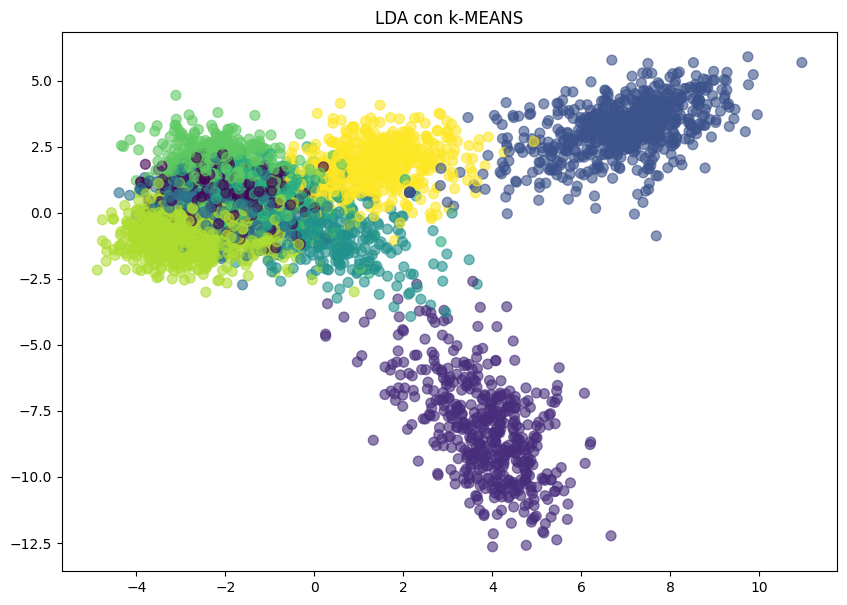

In [29]:
plot_clusters(lda_data_train,labels_kmeans, "LDA con k-MEANS")

FA:

In [25]:
n_components_fa = best_n_components
fa = FA(n_components=n_components_fa)
fa_data_train = fa.fit_transform(fv_train, labels_Train)

In [26]:
n_clusters_fa = best_n_clusters
centroids, labels_kmeans_fa = k_means_imp(fa_data_train, n_clusters_fa)

Métricas:

In [27]:
silhouette_avg_fa = silhouette_score(fa_data_train, labels_kmeans_fa)
rand_index_fa = adjusted_rand_score(labels_Train, labels_kmeans_fa)
mutual_info_fa = adjusted_mutual_info_score(labels_Train, labels_kmeans_fa)

print("Silhouette Score: {:.4f}".format(silhouette_avg_fa))
print("Adjusted Rand Index (ARI): {:.4f}".format(rand_index_fa))
print("Adjusted Mutual Information (AMI): {:.4f}".format(mutual_info_fa))

Silhouette Score: 0.1024
Adjusted Rand Index (ARI): 0.3744
Adjusted Mutual Information (AMI): 0.6188


Gráfico de clusters con FA

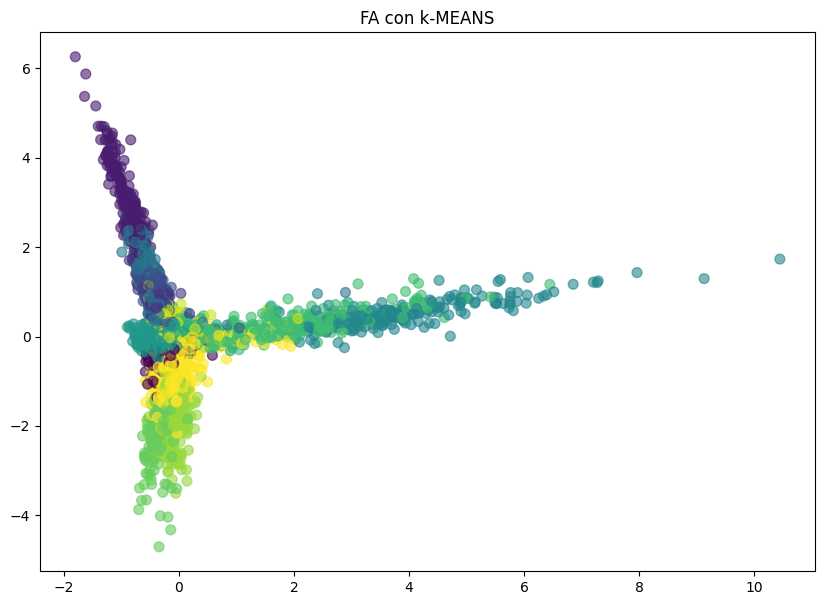

In [30]:
plot_clusters(fa_data_train,labels_kmeans_fa, "FA con k-MEANS")